In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

import am_sim as ams

### Load parameters and dataset

In [2]:
# load search df
df = pd.read_csv('inference_results/t_final_search_history.csv', index_col=0)

# load best parameters set from search dataframe
from utilities.analyze_inference import best_par_in_df
par = best_par_in_df(df)

# load dataset
from utilities.dataset_interface import load_all_datasets
dsets = load_all_datasets()

### Test domain for the deterministic and stochastic model simulations

In [3]:
# dosages and time delays at which to simulate the deterministic and stochastic model in the
# three considered schemes
D_test_1 = np.logspace(-2,1,10)
D_test_2 = np.concatenate([[0],np.logspace(-3,1,13)])
T_test_3 = np.arange(7,56,4)

# collect the domains in a single dictionary
scheme_variable_domain = {
    1 : D_test_1,
    2 : D_test_2,
    3 : T_test_3,
}

### Deterministic model simulation

In [4]:
from utilities.simulate_immschemes import simulate_scheme_1, simulate_scheme_2, simulate_scheme_3

# simulate scheme 1
det_rp_1 = []
for D in D_test_1:
    rp = simulate_scheme_1(sim_type='deterministic', par=par, D=D)
    det_rp_1.append(rp)

# simulate scheme 2
det_rp_2 = []
for D in D_test_2:
    rp = simulate_scheme_2(sim_type='deterministic', par=par, D=D)
    det_rp_2.append(rp)
                            
# simulate scheme 2
det_rp_3 = []
for T in T_test_3:
    rp = simulate_scheme_3(sim_type='deterministic', par=par, T=T)
    det_rp_3.append(rp)

# collect the results in a dictionary, divided by immunization schemes
det_rp_scheme = {
    1 : det_rp_1,
    2 : det_rp_2,
    3 : det_rp_3,
}

### Stochastic model simulations

In [10]:
from utilities.simulate_immschemes import simulate_stoch_scheme_N_times
from utilities.analyze_immscheme import extract_mean_en_and_rhaff

np.random.seed(1) # for precise reproducibility, even though the average results do not depend strongly on the seed used

# NB: in case the simulation is too long one can simply load the results from the next cell

N_sims = 1000 # number of stochastic simulations per simulation-point

# simulate scheme 1
print('simulating scheme 1 ...')
mean_ss_1, rhaff_ss_1 = [], []
for D in D_test_1:
    # perform N_sims stochastic simulations of the immunization scheme and returns a list of responder populations
    rp_list = simulate_stoch_scheme_N_times(scheme_n=1, N_sims=N_sims, par=par, variable=D)
    # extract mean binding energy and high affinity fraction for every responder population
    mean_en_list, r_haff_list = extract_mean_en_and_rhaff(rp_list)
    # append the results
    mean_ss_1.append(mean_en_list)
    rhaff_ss_1.append(r_haff_list)
        
# simulate scheme 2
print('simulating scheme 2 ...')
mean_ss_2, rhaff_ss_2 = [], []
for D in D_test_2:
    rp_list = simulate_stoch_scheme_N_times(scheme_n=2, N_sims=N_sims, par=par, variable=D)
    mean_en_list, r_haff_list = extract_mean_en_and_rhaff(rp_list)
    mean_ss_2.append(mean_en_list)
    rhaff_ss_2.append(r_haff_list)
        
# simulate scheme 3
print('simulating scheme 3 ...')
mean_ss_3, rhaff_ss_3 = [], []
for T in T_test_3:
    rp_list = simulate_stoch_scheme_N_times(scheme_n=3, N_sims=N_sims, par=par, variable=T)
    mean_en_list, r_haff_list = extract_mean_en_and_rhaff(rp_list)
    mean_ss_3.append(mean_en_list)
    rhaff_ss_3.append(r_haff_list)

# collect the results in a dictionary, divided by immunization schemes
mean_ss_scheme = {
    1 : mean_ss_1,
    2 : mean_ss_2,
    3 : mean_ss_3,
}

rhaff_ss_scheme = {
    1 : rhaff_ss_1,
    2 : rhaff_ss_2,
    3 : rhaff_ss_3,
}

# save results in a pickle file
with open('figures/fig_6/stoch_sim_results.pkl', 'wb') as f:
    pkl.dump([mean_ss_scheme, rhaff_ss_scheme], f)
    f.close()

simulating scheme 1 ...
simulating scheme 2 ...
simulating scheme 3 ...


In [5]:
# one can avoid running the stochastic simulations and simply loading the results here
with open('figures/fig_6/stoch_sim_results.pkl', 'rb') as f:
    mean_ss_scheme, rhaff_ss_scheme = pkl.load(f)
    f.close()

### Figure 6

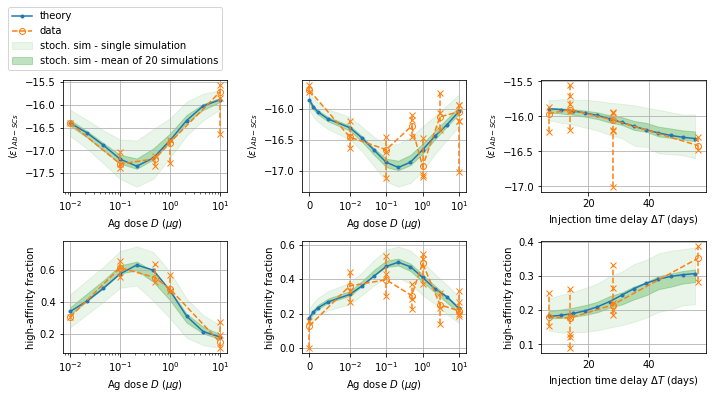

In [6]:
from utilities.plot_dataset import plot_dset_mean_quantities
from utilities.dataset_interface import dataset_idxs_by_scheme
from utilities.plot_det_pop import detpop_color
from utilities.plot_stoch_pop import plot_error_area
from utilities.analyze_immscheme import extract_mean_en_and_rhaff

# create the figure with three subplots
fig, ax = plt.subplots(2,3, figsize = (10,6))

# cycle through the three immunization schemes
for scheme_n in [1,2,3]:

    # plot theory
    x = scheme_variable_domain[scheme_n] # x-variable, either dosage or time delay depending on the immunization scheme
    det_rps = det_rp_scheme[scheme_n] # list of responders populations, one per x-variable
    mean_en_det, rhaff_det = extract_mean_en_and_rhaff(det_rps) # extract mean binding energy and high affinity fraction
    ax[0,scheme_n-1].plot(x, mean_en_det, c=detpop_color, label='theory', marker='.')
    ax[1,scheme_n-1].plot(x, rhaff_det, c=detpop_color, label='theory', marker='.')
    
    # plot stochastic simulations
    N_GCs = 20 # number of GCs for which the variation of the average is considered
    plot_error_area(ax[0,scheme_n-1], mean_ss_scheme[scheme_n], N_GCs=N_GCs, x=x)
    plot_error_area(ax[1,scheme_n-1], rhaff_ss_scheme[scheme_n], N_GCs=N_GCs, x=x)

    
    # select the subset of datsets corresponding to the given scheme
    ds_idxs = dataset_idxs_by_scheme(dsets, scheme_n) # index of selected datasets
    sc_dsts = dsets[ds_idxs] # selected datasets
    
    # plot dataset
    xvariable = 'D' if scheme_n in (1,2) else 'T' # x-variable, either dosage or injection delay
    plot_dset_mean_quantities(ax[0,scheme_n-1], sc_dsts, xvariable, qty='en') # plot binding energies
    plot_dset_mean_quantities(ax[1,scheme_n-1], sc_dsts, xvariable, qty='r_haff') # plot affinities

    
    # set axis, scale and labels
    if scheme_n in [1,2]:
        ax[0,scheme_n-1].set_xlabel(r'Ag dose $D$ ($\mu g$)')
        ax[1,scheme_n-1].set_xlabel(r'Ag dose $D$ ($\mu g$)')
    else:
        ax[0,scheme_n-1].set_xlabel(r'Injection time delay $\Delta T$ (days)')
        ax[1,scheme_n-1].set_xlabel(r'Injection time delay $\Delta T$ (days)')
    ax[0,scheme_n-1].set_ylabel(r'$\langle\epsilon\rangle_{Ab-SCs}$')
    ax[1,scheme_n-1].set_ylabel('high-affinity fraction')
    ax[0,scheme_n-1].grid(True)
    ax[1,scheme_n-1].grid(True)

# extra figure tweaking
for i in range(2):
    ax[i,0].set_xscale('log')
    ax[i,1].set_xscale('symlog', linthreshx=1e-2)
    
ax[0,0].legend(loc='upper right', bbox_to_anchor=(1.,1.7))

plt.tight_layout()
plt.savefig('figures/fig_6/fig_6.pdf')
plt.show()